# Using doNd functions in comparison to Measurement for performing measurements

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be used to perform experiments. The `doNd` functions are generic wrappers of QCoDeS Measurement in zero, one and two dimensions. To have a better picture, we compare doNd and Measurement side-by-side. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single point measurements.

In [1]:
from functools import partial
import os

import time
import numpy as np

from qcodes.utils.dataset.doNd import do1d, do2d, plot
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.dataset.data_set import load_by_run_spec
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doNd.db')
initialise_or_create_database_at(tutorial_db_path)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.84it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


First we setup two dummy instruments to have something to measure. The dmm is setup to generate an output depending on the values set on the dac simulating a real experiment.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

### 1D measurement

##### Measurement

We setup our experiment and perform a measurement using the Measurement framework.

In [4]:
# Creating an experiment
exp1 = load_or_create_experiment('1D_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp1)
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,))

# Running Measurement
with meas.run() as datasaver:
    for dac_sweep in np.linspace(0, 1, 10): # sweep points
        dac.ch1(dac_sweep)
        datasaver.add_result(
            (dac.ch1, dac.ch1()),
            (dmm.v1, dmm.v1()),
            (dmm.v2, dmm.v2())
            )
        time.sleep(0.01) # Can be removed if there is no intention to see a live plot

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment 1D_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #1, Experiment 1D_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

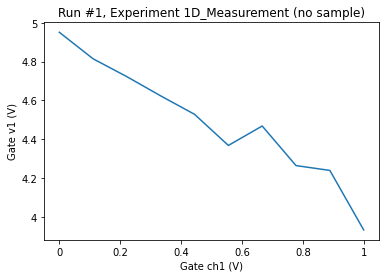

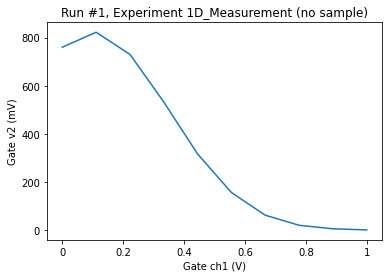

In [5]:
dataset1 = load_by_run_spec(experiment_name='1D_Measurement',\
                           captured_run_id=1)
plot_dataset(dataset1)

##### do1d

Now let us use `do1d` function to perform the above measurement and assign it to a result for further explanations.

In [6]:
# Creating an experiment
exp2 = load_or_create_experiment('1D_do1d', sample_name='no sample')

# Running masurement with do1d
result = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2)

Starting experimental run with id: 2. 


Comparing two frameworks for the same measurement, do1d looks much simpler and easier to use because it has all the Measurement setup under the hood.
By default the `doNd` functions  will not generate a plot of the output. This can be changed in one of two ways. For each individual call to doNd, one can set the value of the keyword argument `do_plot` to True. Alternatively, one can globally set the value of the setting `dataset.dond_plot` in the `qcodesrc.json` configuration file. In the examples below we will often set `do_plot` to True to illustrate how the dond functions work.

Note that for most usecases we recommed using [Plottr](https://github.com/toolsforexperiments/plottr/) for live plotting. See [How to use plottr with QCoDeS for live plotting](../plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) for an introduction to Plottr.

Starting experimental run with id: 3. 


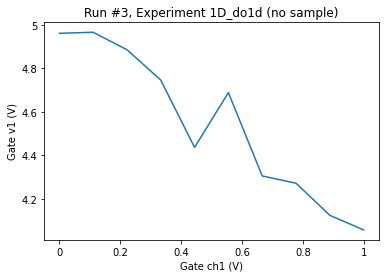

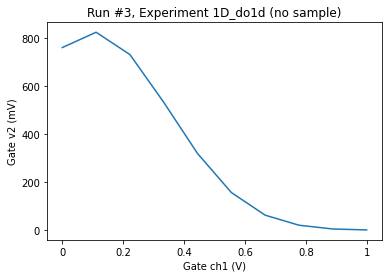

In [7]:
result = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, do_plot = True)

Just note that, because of the implementation of DummyInstrumentWithMeasurement that used for dmm, the results of Measurement and do1d are not exactly the same. If a parameter was used instead to generate the same result for the same input, the results would have been identical.

### 2D measurement

Now, let us have a two dimensional sweep over gate voltages:

##### Measurement

In [8]:
# Creating an experiment
exp3 = load_or_create_experiment('2D_Measurement', sample_name='no sample')

# Setting up Measurement
meas = Measurement(exp3)
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,dac.ch2))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,dac.ch2))

# Running Measurement
with meas.run() as datasaver:
    for dac1_sweep in np.linspace(-1, 1, 20): # sweep points over channel 1
        dac.ch1(dac1_sweep)
        for dac2_sweep in np.linspace(-1, 1, 20): # sweep points over channel 2
            dac.ch2(dac2_sweep)
            datasaver.add_result(
                (dac.ch1, dac.ch1()),
                (dac.ch2, dac.ch2()),
                (dmm.v1, dmm.v1()),
                (dmm.v2, dmm.v2())
                )
            time.sleep(0.01) # Can be removed if there is no intention to see a live plot

Starting experimental run with id: 4. 


([<AxesSubplot:title={'center':'Run #4, Experiment 2D_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #4, Experiment 2D_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x16cff5ec788>])

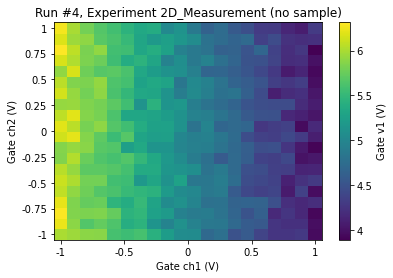

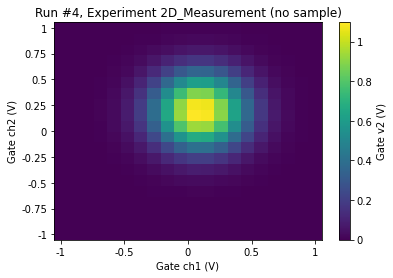

In [9]:
dataset2 = load_by_run_spec(experiment_name='2D_Measurement',\
                           captured_run_id=4)
plot_dataset(dataset2)

##### do2d

Again, we use `do2d` to produce the results for the above measurement. As explained earlier, the results might look different compared to the Measurement section

Starting experimental run with id: 5. 


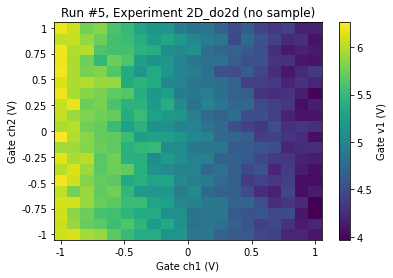

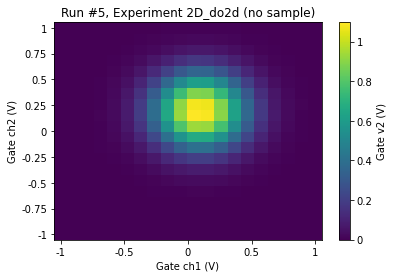

In [10]:
# Creating an experiment
exp4 = load_or_create_experiment('2D_do2d', sample_name='no sample')

# Running masurement with do2d
result = do2d(dac.ch1, -1, 1, 20, 0.01, dac.ch2, -1, 1, 20, 0.01, dmm.v1, dmm.v2, do_plot = True)

### Handling plot and experiment with doNd

The `doNd` utility, in fact, uses an internal public function called `plot` to handle data visualization, which by default saves the figures in both pdf and png formats, as well. Therefore, users, if needed, can only do their measurements leaving to set `do_plot`, which by default is False, then pass the relevant dataset to `plot` when visualization is necessary and choose to save figures in a desired format.

Internally, the `doNd` functions return a tuple consists of the dataset obtained in the measurement, the boolean value correponding to `do_plot` and a callable which checks whether the experiment is interupted by the user. Thus, if the `plot` shall be used explicitly after the measurement, one has to pass the first argument of the return value.

Moreover, it is possible to pass an already existing experiment as an argument to `doNd` constructor. This is usually a convenient way as users may prefer not to create a new experiment before running a measurement with `doNd`s. 

In [11]:
result_1d = do1d(dac.ch1, 0, 0.25, 10, 0.01, dmm.v1, dmm.v2, exp=exp2)

Starting experimental run with id: 6. 


In [12]:
result_2d = do2d(dac.ch1, -0.6, 0.6, 20, 0.01, dac.ch2, -0.6, 0.6, 20, 0.01, dmm.v1, dmm.v2, exp=exp4)

Starting experimental run with id: 7. 


(results #6@C:\Users\a-fbonabi\Desktop\tutorial_doNd.db
 ------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #6, Experiment 1D_do1d (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #6, Experiment 1D_do1d (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v2 (mV)'>],
 [None, None])

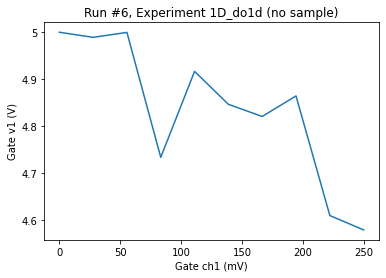

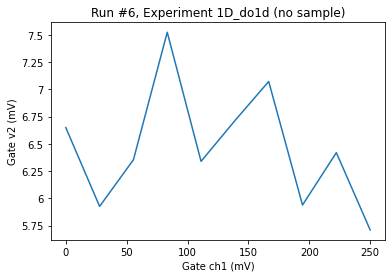

In [13]:
plot(result_1d[0], save_pdf = False, save_png =True)

(results #7@C:\Users\a-fbonabi\Desktop\tutorial_doNd.db
 ------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #7, Experiment 2D_do2d (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>,
  <AxesSubplot:title={'center':'Run #7, Experiment 2D_do2d (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x16cff4ca4c8>])

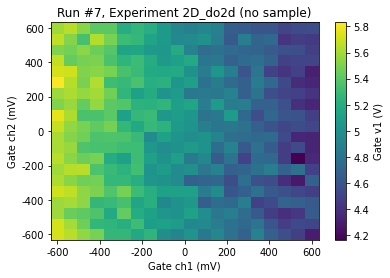

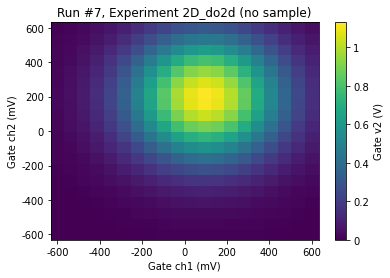

In [14]:
plot(result_2d[0], save_pdf = True, save_png = False)